In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

# Create a folder
folders = ["Timetables"]
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [2]:
# Input the time slots of courses
# SCM3202 = ["L01,Danny Ho,Tue 09:00-10:30 (M1006),Fri 12:00-13:30 (M1008)",
#            "L02,Danny Ho,Tue 10:30-12:00 (M1006),Fri 13:30-15:00 (M1008)",
#            "L03,Timothy Chau,Tue 12:00-15:00 (M1008)",
#            "L04,Timothy Chau,Wed 09:00-12:00 (D410)",
#            "L05,Timothy Chau,Thu 10:30-13:30 (A213)",
#            "L06,Timothy Chau,Thu 16:30-19:30 (M906)",
#            "L07,Timothy Chau,Mon 09:00-12:00 (A314)"
#            ]

SCM3202 = ["L03,Timothy Chau,Tue 12:00-15:00 (M1008)",
           "L04,Timothy Chau,Wed 09:00-12:00 (D410)",
           "L05,Timothy Chau,Thu 10:30-13:30 (A213)",
           "L06,Timothy Chau,Thu 16:30-19:30 (M906)",
           "L07,Timothy Chau,Mon 09:00-12:00 (A314)"
           ]

SCM3101 = ["L01,Valerie Tang,Mon 09:00-12:00 (M803)",
           "L02,Valerie Tang,Mon 16:30-19:30 (M803)",
           "L03,Valerie Tang,Thu 16:30-19:30 (M803)",
           "L04,Valerie Tang,Fri 09:00-12:00 (M803)"
           ]

ACY2101 = ["L01,Ivy Leung,Tue 12:00-15:00 (D603)",
           "L02,Ivy Leung,Wed 09:00-12:00 (D203)",
           "L03,Ivy Leung,Wed 15:00-18:00 (D203)",
           "L04, Ivy Leung,Fri 12:00-15:00 (A404)",
           "L05,Ricky Lam,Thu 10:30-13:30 (A305)"
           ]

ACY2021 = ["L05,Johnson Shum,Mon 15:00-18:00 (M907)",
           "L06,Johnson Shum,Mon 09:00-12:00 (M904)",
           "L07,Johnson Shum,Tue 13:30-16:30 (A305)"
           ]

CHN1002 = ["L07,Au Yik Sau,Thu 12:00-13:30 (A304),Fri 16:30-18:00 (A301)",
           "L08,Au Yik Sau,Wed 13:30-15:00 (D409),Fri 09:00-10:30 (A214)",
           "L09,Lam Wing Kin,Tue 12:00-13:30 (M1006),Fri 12:00-13:30 (M907)",
           "L10,Lam Wing Kin,Tue 15:00-16:30 (A303),Tue 09:00-10:30 (A212)",
           "L11,Lam Wing KIn,Mon 13:30-15:00 (D408),Fri 09:00-10:30 (D406)"
           ]

ENG2001 = ["L01,Ophelia Tung,Mon 15:00-17:00 (N303)",
           "L02,Ophelia TUng,Fri 12:00-14:00 (N201)",
           "L03,Ophelia Tung,Wed 13:30-15:30 (D310)",
           "L04,Amy Kong,Tue 16:30-18:30 (M909)",
           "L05,Amy Kong,Fri 15:00-17:00 (N304)"
           ]

CHN2007 = ["L01,Ling Chung Wing,Mon 09:00-12:00 (M706)",
            "L02,Ling Chung Wing,Wed 09:00-12:00 (A212)"
            ]

CHN2009 = ["L02,Cathy Fung,Thu 09:00-12:00 (M1007)"]

sem = "Year 2 Spring"
courses = [SCM3202, SCM3101, ACY2021, CHN1002, ENG2001, CHN2007]
# courses = [SCM3202, SCM3101, ACY2021, CHN1002, ENG2001, CHN2009]
courses_label = [name for name, value in globals().items() if value in courses]

In [3]:
# Define a dictionary that maps weekdays to corresponding numerical values
weekdays = {"Mon": 100, "Tue": 200, "Wed": 300, "Thu": 400, "Fri": 500, "Sat": 600, "Sun": 700}

# Function to extract the section from a given time slot
def get_section(slot):
    return slot.split(",")[0]

# Function to extract the instructor from a given time slot
def get_instructor(slot):
    return slot.split(",")[1]

# Function to extract the time range from a given time slot
def get_time(slot):
    split = slot.split(",")
    length = len(split)
    if length > 2:
        return split[2:]

# Convert a time range in the format "hh:mm-hh:mm" to decimal representation
def range_to_decimal(range):
    start_time, end_time = range.split("-")
    start_hours, start_minutes = map(int, start_time.split(":"))
    end_hours, end_minutes = map(int, end_time.split(":"))
    return start_hours + start_minutes / 60, end_hours + end_minutes / 60

# Check if there is any overlap between two time slots
def check_overlap(time1, time2):
    for t1 in time1:
        day1, range1, room1 = t1.split()
        # Calculate the start and end times for the first time slot
        arr1 = weekdays[day1] + np.array(range_to_decimal(range1))
        for t2 in time2:
            day2, range2, room2 = t2.split()
            # Calculate the start and end times for the second time slot
            arr2 = weekdays[day2] + np.array(range_to_decimal(range2))
            # Check if there is any overlap between the two time slots
            if max(arr1) >= min(arr2) and min(arr1) <= max(arr2):
                return True
    return False

# Check if there is any overlap among multiple time slots
def check_overlap_multiple(times):
    # Generate all possible combinations of time slots
    for time_pair in itertools.combinations(times, 2):
        # Check if there is any overlap between each pair of time slots
        if check_overlap(*time_pair):
            return True
    return False

In [9]:
# Generate all possible timetables based on courses
timetables = []
for timetable in itertools.product(*courses):
    times = [get_time(course) for course in timetable]

    # Check for overlap in the timetable
    if not check_overlap_multiple(times):
        timetables.append(list(timetable))

print(f"The number of possible timetables is {len(timetables)}.\n")

# Calculate durations and start times for each day
def calculate_time_stats(timetable):
    days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
    durations = [0, 0, 0, 0, 0]
    start_times = [0, 0, 0, 0, 0]
    end_times = [0, 0, 0, 0, 0]
    for slot in timetable:
        for t in slot.split(",")[2:]:
            day, time_range, room = t.split()
            index = days.index(day)
            start_time, end_time = range_to_decimal(time_range)
            durations[index] += end_time - start_time
            if start_times[index] == 0 or start_time < start_times[index]:
                start_times[index] = start_time
            if end_times[index] == 0 or end_time > end_times[index]:
                end_times[index] = end_time
    return durations, start_times, end_times

# Calculate the score for a timetable
def get_score(timetable):
    score = 100
    weight_d = 5
    day_off = 10
    weight_s = 5
    weight_e = 5
    durations, start_times, end_times = calculate_time_stats(timetable)

    for duration in durations:
        if duration > 5:
            score -= (duration - 5) * weight_d
        if duration == 0:
            score += day_off
    for start_time in start_times:
        if 0 < start_time < 11:
            score -= weight_s * (11 - start_time)
    for end_time in end_times:
        if 0 < end_time and end_time > 17.5:
            score -= weight_e * (end_time - 17.5)
    return score

scores = []
for i, timetable in enumerate(timetables):
    # Calculate the score for each timetable and store the index-score tuples
    score = get_score(timetable)
    scores.append((i, score))

# Sort the timetables in descending order based on scores
scores.sort(key=lambda x: x[1], reverse=True)
timetables_sorted = [timetables[index] for index, score in scores]

# Print the top 10 timetables with their scores
for i, timetable in enumerate(timetables_sorted[:10]):
    print(f"Timetable: {timetable}")
    durations, start_times, end_times = calculate_time_stats(timetable)
    print(f"Durations: {durations}")
    print(f"Start times: {start_times}")
    print(f"End times: {end_times}")
    print(f"Score: {scores[i][1]}\n")

The number of possible timetables is 275.

Timetable: ['L03,Timothy Chau,Tue 12:00-15:00 (M1008)', 'L03,Valerie Tang,Thu 16:30-19:30 (M803)', 'L05,Johnson Shum,Mon 15:00-18:00 (M907)', 'L07,Au Yik Sau,Thu 12:00-13:30 (A304),Fri 16:30-18:00 (A301)', 'L02,Ophelia TUng,Fri 12:00-14:00 (N201)', 'L01,Ling Chung Wing,Mon 09:00-12:00 (M706)']
Durations: [6.0, 3.0, 0, 4.5, 3.5]
Start times: [9.0, 12.0, 0, 12.0, 12.0]
End times: [18.0, 15.0, 0, 19.5, 18.0]
Score: 80.0

Timetable: ['L06,Timothy Chau,Thu 16:30-19:30 (M906)', 'L04,Valerie Tang,Fri 09:00-12:00 (M803)', 'L07,Johnson Shum,Tue 13:30-16:30 (A305)', 'L07,Au Yik Sau,Thu 12:00-13:30 (A304),Fri 16:30-18:00 (A301)', 'L01,Ophelia Tung,Mon 15:00-17:00 (N303)', 'L01,Ling Chung Wing,Mon 09:00-12:00 (M706)']
Durations: [5.0, 3.0, 0, 4.5, 4.5]
Start times: [9.0, 13.5, 0, 12.0, 9.0]
End times: [17.0, 16.5, 0, 19.5, 18.0]
Score: 77.5

Timetable: ['L06,Timothy Chau,Thu 16:30-19:30 (M906)', 'L04,Valerie Tang,Fri 09:00-12:00 (M803)', 'L07,Johnson Shum

In [11]:
# Save the top 10 timetables with their scores to a text file
with open(f"timetables ({sem}).txt", "w") as file:
    for i, timetable in enumerate(timetables_sorted[:10]):
        file.write(f"Timetable: {timetable}\n")
        durations, start_times, end_times = calculate_time_stats(timetable)
        file.write(f"Durations: {durations}\n")
        file.write(f"Start times: {start_times}\n")
        file.write(f"End times: {end_times}\n")
        file.write(f"Score: {scores[i][1]}\n\n")

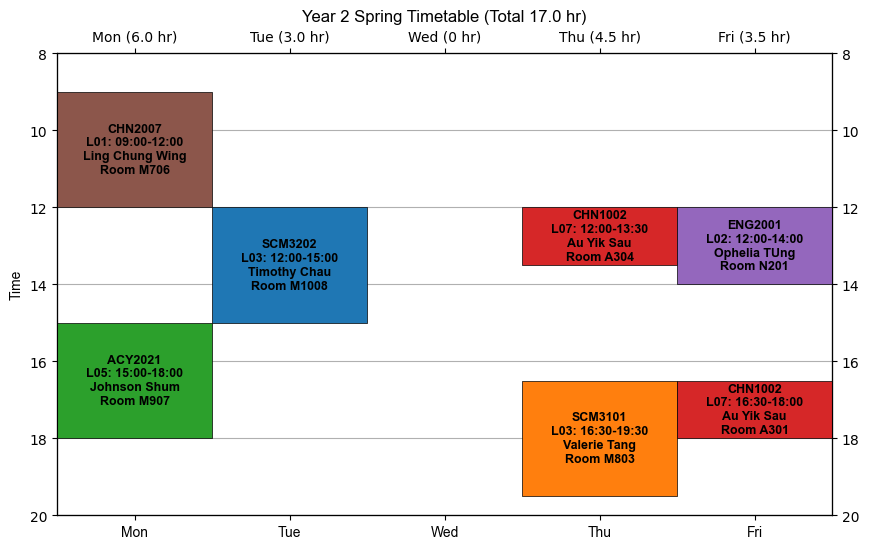

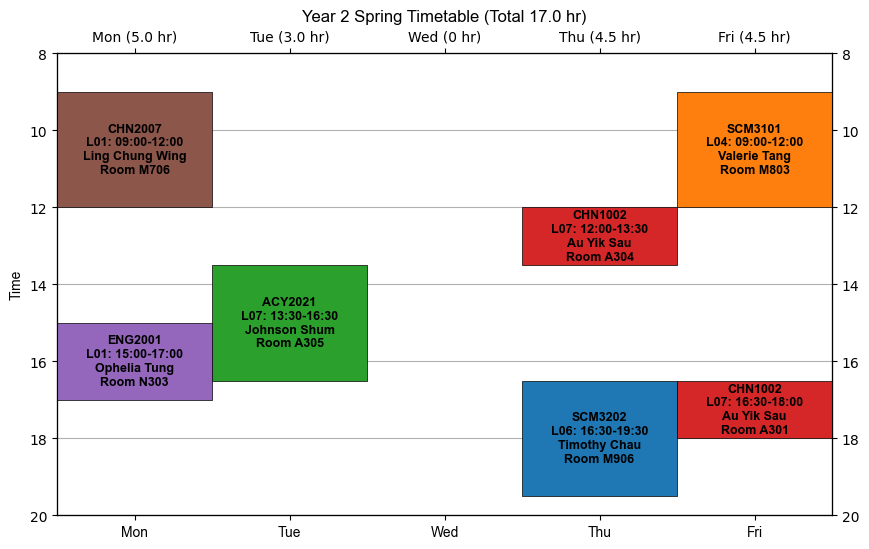

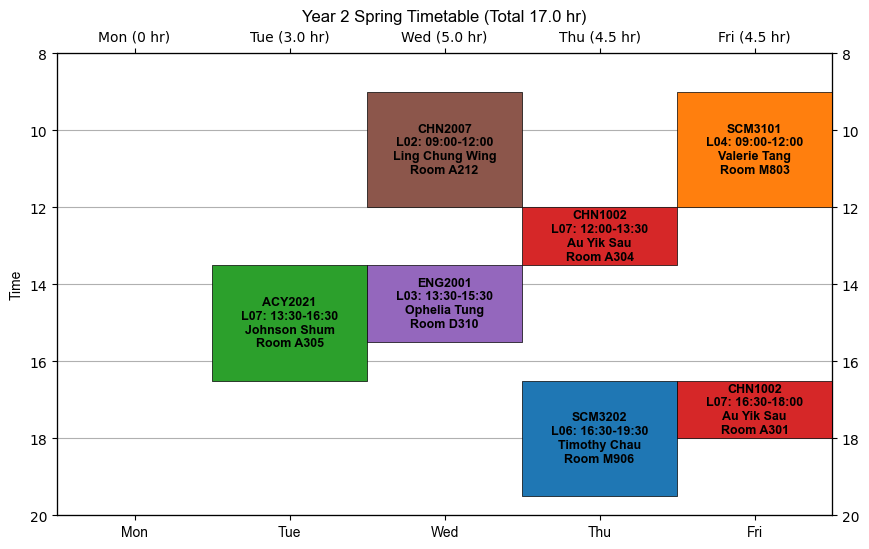

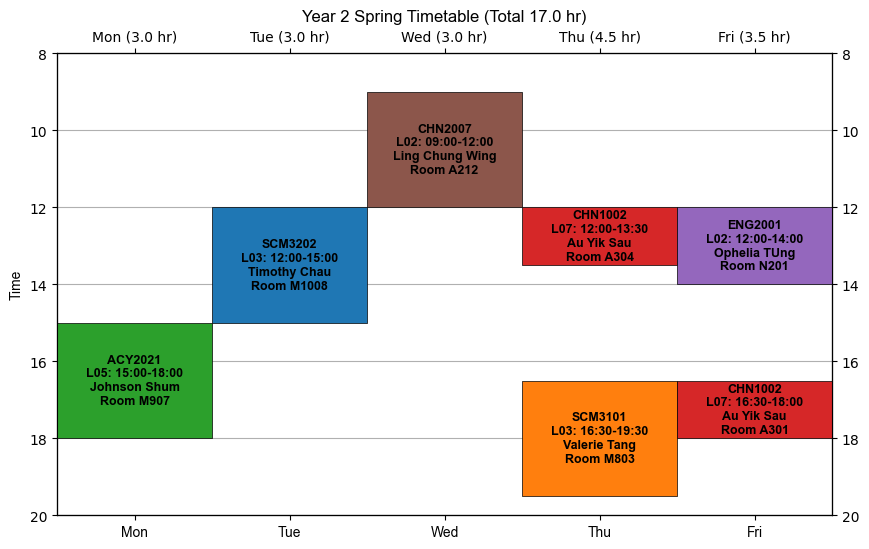

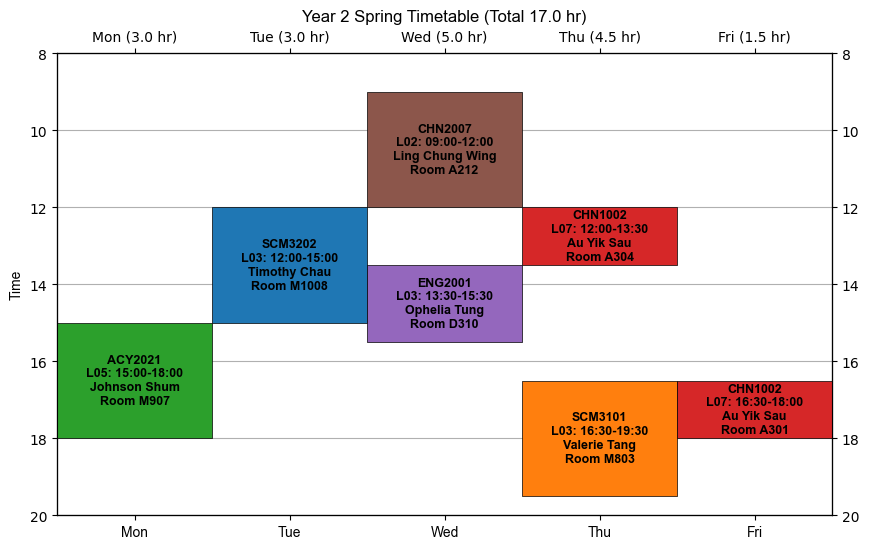

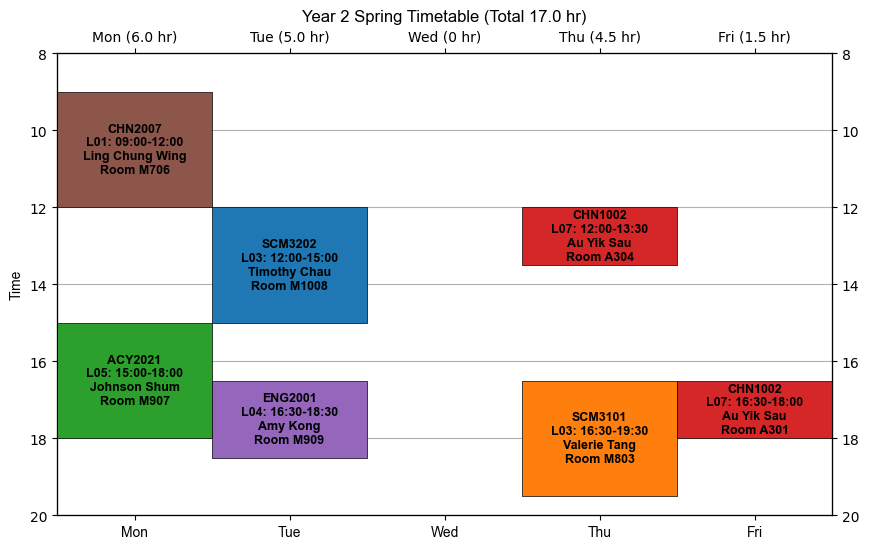

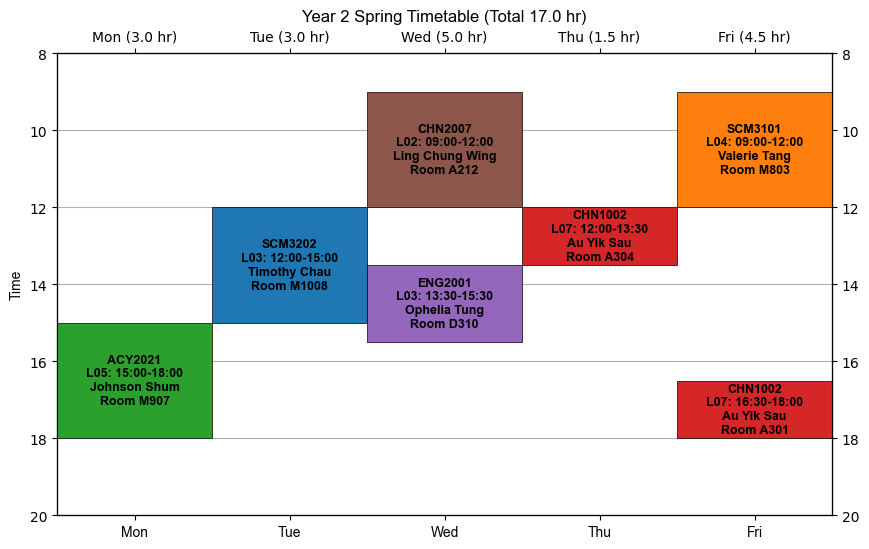

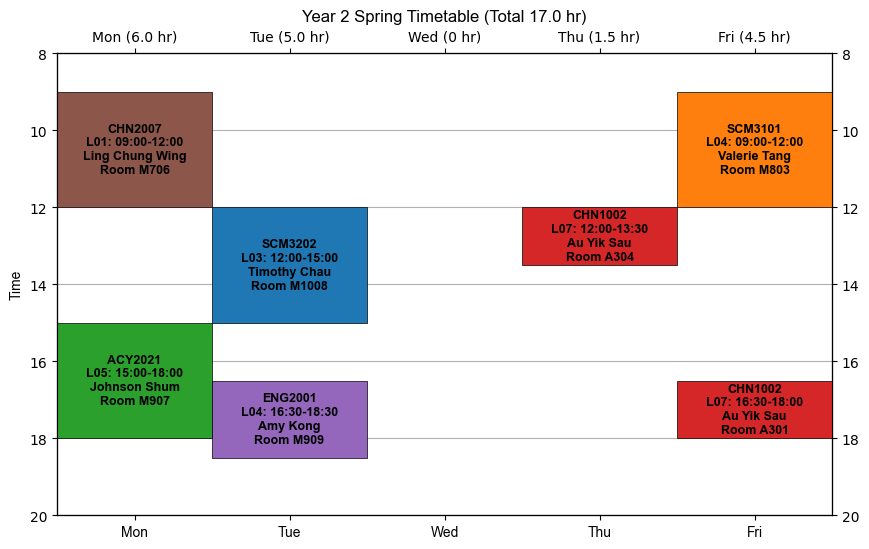

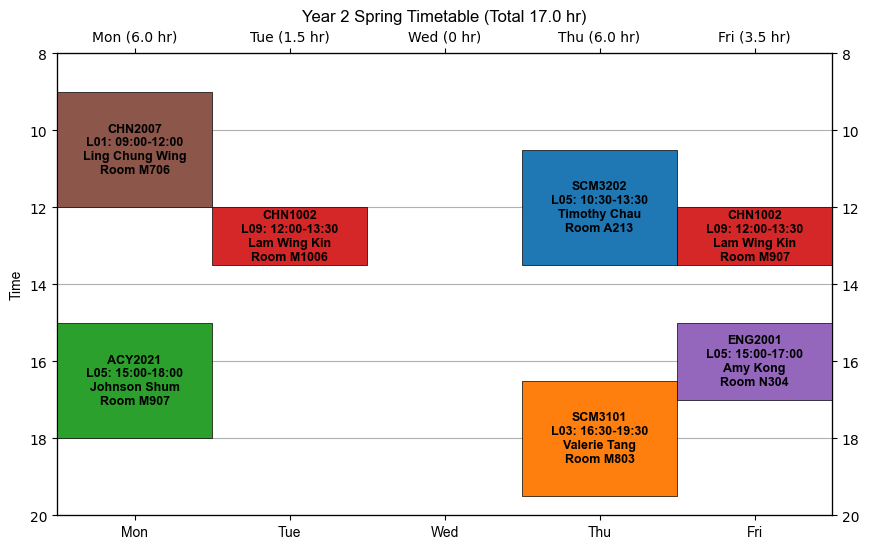

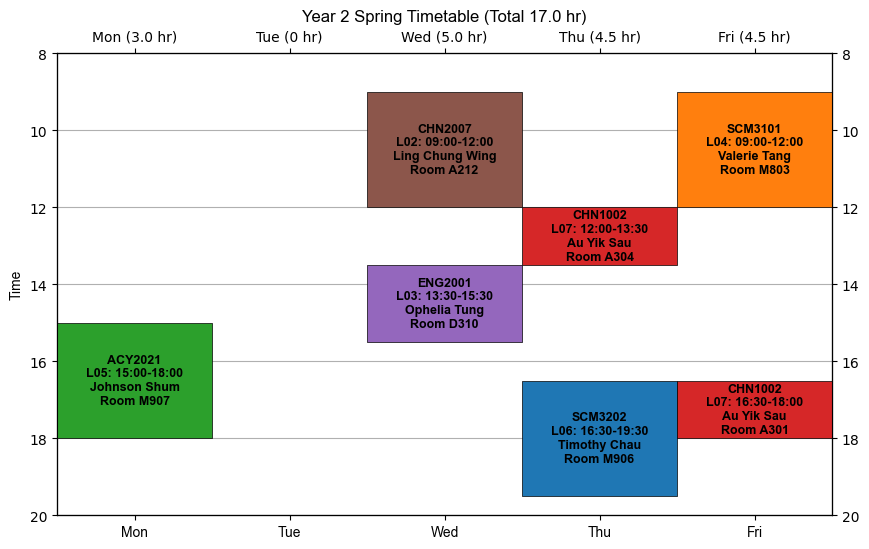

In [12]:
# Visualize a timetable
def visualize(timetables):
    for i, timetable in enumerate(timetables):
        durations, start_times, end_times = calculate_time_stats(timetable)
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

        # Set Axis
        ax.yaxis.grid()
        ax.set_xlim(0.5, 5.5)
        ax.set_ylim(20, 8)
        ax.set_xticks(range(1, 6))
        ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri"], fontname="Arial")
        ax.set_ylabel("Time", fontname="Arial")

        # Set Second Axis
        ax2 = ax.twiny().twinx()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim(ax.get_ylim())
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels([f"Mon ({durations[0]} hr)", f"Tue ({durations[1]} hr)", f"Wed ({durations[2]} hr)", f"Thu ({durations[3]} hr)", f"Fri ({durations[4]} hr)"], fontname="Arial")

        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for j, slot in enumerate(timetable):
            course = courses_label[j]
            section = get_section(slot)
            instructor = get_instructor(slot)
            color = colors[j]
            for t in slot.split(",")[2:]:
                day, time_range, room = t.split()
                day = weekdays[day] / 100
                start_time, end_time = range_to_decimal(time_range)
                label = f"{course}\n{section}: {time_range}\n{instructor}\nRoom {room[1:-1]}"
                plt.fill_between([day - 0.5, day + 0.5], [start_time, start_time], [end_time, end_time], color=color, edgecolor="k", linewidth=0.5)
                # Plot the lecture
                plt.text(day, (start_time + end_time) * 0.5, label, ha="center", va="center", fontsize=9, fontname="Arial", fontweight="bold")

        plt.title(f"{sem} Timetable (Total {sum(durations)} hr)", fontname="Arial")
        plt.savefig(f"Timetables/{sem.replace(' ', '').lower()}timetable{i+1}.png")
        plt.show()

visualize(timetables_sorted[:10])